In [ ]:
import gym
import numpy as np 
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import random
def generate(size=8, p=None):
    if p == None or p == 0:
        p = random.uniform(0.1, 1)
    valid = False
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True
        
        tmp = arr[r][c]
        arr[r][c] = "#"
        
        if r+1 < size and arr[r+1][c] not in '#H':
            if is_valid(arr, r+1, c) == True:
                arr[r][c] = tmp
                return True
        
        if c+1 < size and arr[r][c+1] not in '#H':
            if is_valid(arr, r, c+1) == True:
                arr[r][c] = tmp
                return True
        
        if r-1 >= 0 and arr[r-1][c] not in '#H':
            if is_valid(arr, r-1, c) == True:
                arr[r][c] = tmp
                return True
        
        if c-1 >= 0 and arr[r][c-1] not in '#H':
            if is_valid(arr,r, c-1) == True:
                arr[r][c] = tmp
                return True
        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F','H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
        p *= 1.1
    return ["".join(x) for x in res]

In [ ]:
def one_hot(ids, nb_digits):
    """
    ids: (list, ndarray) shape:[batch_size]
    """
    if not isinstance(ids, (list, np.ndarray)):
        raise ValueError("ids must be 1-D list or array")
    batch_size = len(ids)
    ids = torch.LongTensor(ids).view(batch_size, 1)
    out_tensor = Variable(torch.FloatTensor(batch_size, nb_digits))
    out_tensor.data.zero_()
    out_tensor.data.scatter_(dim=1, index=ids, value=1.)
    return out_tensor

def uniform_linear_layer(linear_layer):
    linear_layer.weight.data.uniform_()
    linear_layer.bias.data.fill_(-0.02)

In [3]:
# lake = gym.make('FrozenLake-v0')
lake = generate(4)

[2018-01-20 15:56:13,679] Making new env: FrozenLake-v0


In [4]:
class Agent(nn.Module):
    def __init__(self, observation_space_size, action_space_size):
        super(Agent, self).__init__()
        self.observation_space_size = observation_space_size
        self.hidden_size = observation_space_size
        self.l1 = nn.Linear(in_features=observation_space_size, out_features=self.hidden_size)
        self.l2 = nn.Linear(in_features=self.hidden_size, out_features=action_space_size)
        uniform_linear_layer(self.l1)
        uniform_linear_layer(self.l2)
    
    def forward(self, state):
        obs_emb = one_hot([int(state)], self.observation_space_size)
        out1 = F.sigmoid(self.l1(obs_emb))
        return self.l2(out1).view((-1)) # 1 x ACTION_SPACE_SIZE == 1 x 4  =>  4

In [5]:
class Trainer:
    def __init__(self):
        self.agent = Agent(lake.observation_space.n, lake.action_space.n)
        self.optimizer = optim.Adam(params=self.agent.parameters())
        self.success = []
        self.jList = []
    
    def train(self, epoch):
        for i in range(epoch):
            s = lake.reset()
            j = 0
            while j < 200:
                
                # perform chosen action
                a = self.choose_action(s)
                s1, r, d, _ = lake.step(a)
                if d == True and r == 0: r = -1
                
                # calculate target and loss
                target_q = r + 0.99 * torch.max(self.agent(s1).detach()) # detach from the computing flow
                loss = F.smooth_l1_loss(self.agent(s)[a], target_q)
                
                # update model to optimize Q
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # update state
                s = s1
                j += 1
                if d == True: break
            
            # append results onto report lists
            if d == True and r > 0:
                self.success.append(1)
            else:
                self.success.append(0)
            self.jList.append(j)
        print("last 100 epoches success rate: " + str(sum(self.success[-100:])) + "%")

    def choose_action(self, s):
        if (np.random.rand(1) < 0.1): 
            return lake.action_space.sample()
        else:
            agent_out = self.agent(s).detach()
            _, max_index = torch.max(agent_out, 0)
            return max_index.data.numpy()[0]

In [6]:
t = Trainer()
t.train(2000)

last 100 epoches success rate: 33%


In [19]:
t.agent.l2.weight

Parameter containing:

Columns 0 to 9 
-0.0432 -0.0276  0.5012  0.2761 -0.2207  0.4896  0.5948 -0.1860 -0.2294 -0.0896
-0.3062 -0.1764  0.6025  0.3882 -0.2758  0.4798  0.1217  0.7973  0.0417 -0.2815
-0.1985  0.2487  0.0153 -0.3652  0.6703  0.0448 -0.0394  0.5981  0.6360 -0.3731
 0.2278  0.1463 -0.0798 -0.1995  0.3256  0.6826 -0.1278  0.0376  0.4560 -0.3958

Columns 10 to 15 
 0.1483  0.5209 -0.2749  0.5598  0.5894  0.3385
 0.5207  0.3583  0.0573  0.2121  0.4330  0.4630
 0.3446  0.4788  0.3007  0.0226  0.5548  0.1567
 0.4759  0.3984  0.6510  0.5589 -0.1216  0.4036
[torch.FloatTensor of size 4x16]

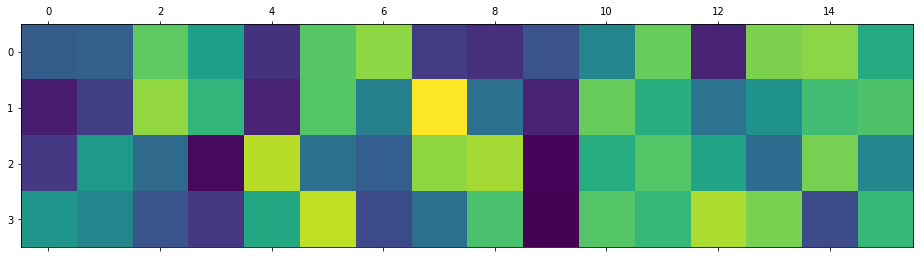

In [20]:
plt.matshow(t.agent.l2.weight.data.numpy())